In [2]:
#import matplotlib
#matplotlib.use('nbagg')

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#inspector = inspect(engine)
#inspector.get_table_names()

#columns = inspector.get_columns('measurement')
#for c in columns:
#    print(c['name'], c["type"])
#id INTEGER, station TEXT, date TEXT, prcp FLOAT, tobs FLOAT
    
#session.query(func.count(Measurement.date)).all() A: 19550
#Earliest date
#session.query(Measurement.date).order_by(Measurement.date).first() A: ('2010-01-01')
#session.query(Measurement.date).order_by(Measurement.date.desc()).first() A: ('2017-08-23')
measureprcp = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date > '2016-08-31').all()

# Calculate the date 1 year ago from the last data point in the database
last_date = dt.datetime.strptime("2017-08-23", "%Y-%m-%d")
print(type(last_date))

year_ago = last_date - dt.timedelta(days=365)
print(year_ago)

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

#Use Pandas Plotting with Matplotlib to plot the data
df = pd.DataFrame(measureprcp, columns=['date', 'prcp'])
df.head()




<class 'datetime.datetime'>
2016-08-23 00:00:00


,date,prcp
0,2016-09-01,0.00
1,2016-09-02,0.00
2,2016-09-03,0.00
3,2016-09-04,0.03
4,2016-09-05,NaN


In [15]:
df.set_index(df['date'], inplace=True)
df.head()

,date,prcp
date,,
2016-09-01,2016-09-01,0.00
2016-09-02,2016-09-02,0.00
2016-09-03,2016-09-03,0.00
2016-09-04,2016-09-04,0.03
2016-09-05,2016-09-05,NaN


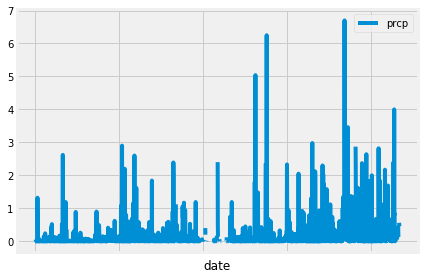

In [16]:
df.plot(x_compat = True)
plt.xticks(rotation = '45')
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,1968.000000
mean,0.171479
std,0.451817
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
inspector2 = inspect(engine)
inspector2.get_table_names()

columns = inspector2.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
    
session.query(func.count(Station.station)).all()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
session.query(func.count(Measurement.station), (Measurement.station)).group_by(Measurement.station).all()

# List the stations and the counts in descending order
session.query(func.count(Measurement.station), (Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(func.min(Measurement.tobs), (func.max(Measurement.tobs)), (func.avg(Measurement.tobs))).\
                filter(Measurement.station == "USC00519281").all()
print(lowest_temp)





[(54.0, 85.0, 71.66378066378067)]


In [48]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
total_temp = session.query(Measurement.tobs).\
                filter((Measurement.station == "USC00519281") and (Measurement.date > '2016-08-31')).all()
#print(total_temp)


In [30]:
#Use Pandas Plotting with Matplotlib to plot the data
Temp = pd.DataFrame(total_temp, columns=['tobs'])
#Temp

#Create the bins
bins = [0, 59, 65, 70, 75, 80, 83]

#Create the names for the bins
group_names = ["<60", "60-65", "66-70", "71-75", "76-80", "81+"]



In [39]:
Temp["Temp Group"] = pd.cut(Temp["tobs"], bins, labels=group_names)
#Temp

temp_gp = Temp.groupby(["Temp Group"]).count()['tobs']
print(temp_gp)

summary_tbl = pd.DataFrame({"Frequency": temp_gp})
summary_tbl

Temp Group
<60        22
60-65     216
66-70     754
71-75    1298
76-80     444
81+        36
Name: tobs, dtype: int64


,Frequency
Temp Group,
<60,22
60-65,216
66-70,754
71-75,1298
76-80,444
81+,36


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000275D53AFE80>]],
      dtype=object)

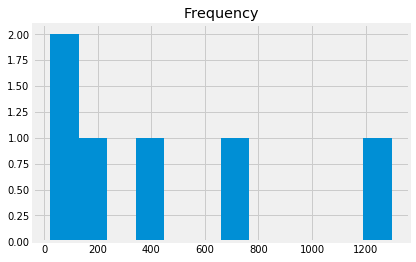

In [47]:
summary_tbl.hist(column='Frequency', bins=12)

![precipitation](Images/station-histogram.png)

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2016-09-15', '2016-09-25')



[(70.0, 77.77142857142857, 83.0)]

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#cities = ["New Orleans", "Milwaukee", "Omaha", "Pittsburgh", "Toledo"]
#bars_in_cities = [8.6, 8.5, 8.3, 7.9, 7.2]
#x_axis = np.arange(len(bars_in_cities))
#plt.bar(x_axis, bars_in_cities, color="b", align="center")

In [55]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_prcp(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
        
print(calc_prcp('2012-02-28', '2012-03-05'))


[('USC00519281', 11.08), ('USC00516128', 10.32), ('USC00513117', 5.79), ('USC00518838', 3.8400000000000003), ('USC00519523', 2.92), ('USC00519397', 1.1800000000000002), ('USC00511918', 0.76), ('USC00514830', 0.03), ('USC00517948', 0.0)]


In [56]:
#Complete the join


<bound method Query.all of <sqlalchemy.orm.query.Query object at 0x00000275D5441668>>

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
